

Model Type: MAE
MAE: 4.560936191573976e-05, RMSE: 0.00036663800964695605, R2: 0.3630453095989913
Mean of y_test: 0.00019686996797655434, Std of y_test: 0.0004593918130204109


Model Type: RMSE
MAE: 4.560936191573976e-05, RMSE: 0.00036663800964695605, R2: 0.3630453095989913
Mean of y_test: 0.00019686996797655434, Std of y_test: 0.0004593918130204109


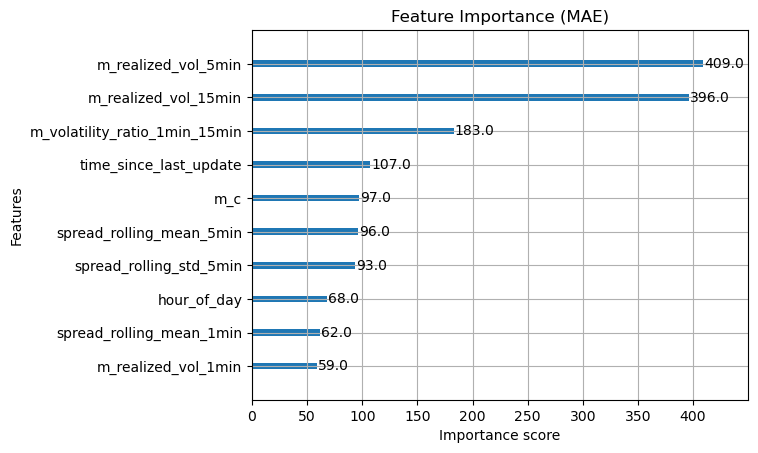

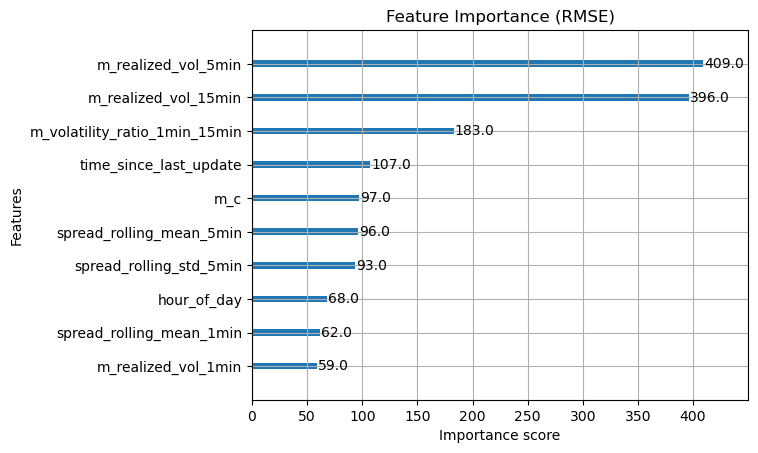

In [ ]:
import xgboost as xgb
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
model_paths = { 'MAE': 'xgb_model_rv5min_MAE.json', 'RMSE': 'xgb_model_rv5min_RMSE.json' }

%run ../risk_estimator/data_loader.py
X_test, y_test = get_data('test')

def load_model(model_type):
    model = xgb.XGBRegressor()
    model.load_model('../' + model_paths[model_type])
    return model

def report_feature_importance_and_metrics(model_type):
    model = load_model(model_type)
    xgb.plot_importance(model, max_num_features=10, title=f'Feature Importance ({model_type})')
    y_pred = model.predict(X_test)
    # Out-of-sample evaluation
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    r2score = model.score(X_test, y_test)
    print(f"\n\nModel Type: {model_type}")
    print(f"MAE: {mae}, RMSE: {rmse}, R2: {r2score}")
    print(f"Mean of y_test: {y_test.mean()}, Std of y_test: {y_test.std()}")

for model_type in model_paths.keys():
    report_feature_importance_and_metrics(model_type)

# Conclusions:
# - the two models, RMSE and MAE, have identical metrics on the test set

/Users/janul/Python/FX/expert-sniffle/risk_estimator/plotting.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby('bin').agg(
/Users/janul/Python/FX/expert-sniffle/risk_estimator/plotting.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg['mean_pred_for_bin'] = df.groupby('bin')['y_pred_for_bin'].mean().values


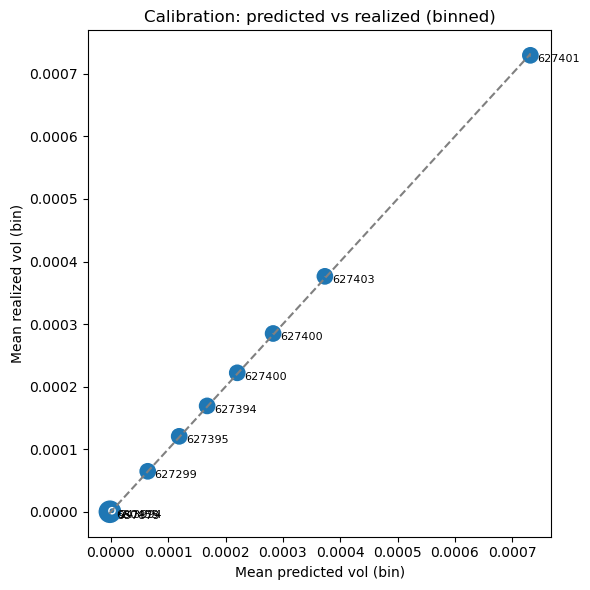

In [17]:
model = load_model('RMSE')
y_pred = model.predict(X_test)
%run ../risk_estimator/plotting.py
# Example usage:
agg = calibration_by_bins(y_test, y_pred, n_bins=10, method='quantile', log_transform=True)
fig, ax = plot_calibration(agg)
plt.show()